#  Model Training: Waste Classification using Deep Learning (ResNet50)

###  Introduction

This notebook focuses on training a deep learning model for **automated waste classification** as part of a broader initiative to design a smart and sustainable waste sorting system.

Using a dataset of beverage container images categorized into **Glass**, **Metal**, **Paper**, and **Plastic**, we train a neural network to accurately classify waste materials based on visual features. This model plays a key role in enabling intelligent sorting within a real-world recycling pipeline.

###  Tools & Frameworks
- **TensorFlow** and **Keras** for model development and training  
- **Image preprocessing** and **data augmentation** to improve generalization  
- **Categorical classification** with performance monitoring using metrics like accuracy and loss  

###  Objectives
- Load and preprocess image data from a labeled dataset  
- Define and train a convolutional neural network (CNN)  
- Evaluate model performance on unseen data  
- Save the trained model for deployment in an automated waste sorting system  

This training process lays the foundation for building an intelligent, automated sorting solution that contributes to reducing landfill waste and advancing environmental sustainability.


###  Importing Libraries

In this step, we import all the necessary Python libraries required for data loading, preprocessing, model training, evaluation, and visualization.

- **os, numpy**: Core libraries for file handling and numerical operations.
- **matplotlib, seaborn**: For visualizing training performance and results like accuracy, loss curves, and confusion matrices.
- **TensorFlow & Keras**: For building, training, and evaluating deep learning models.
- **ImageDataGenerator**: To apply real-time data augmentation during training.
- **scikit-learn**: To generate classification reports and confusion matrices for performance analysis.

These libraries provide the essential tools to develop a robust image classification pipeline for the smart waste sorting system.


In [1]:
# Import Core Libraries
import warnings
import os
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras.layers as tkl

# TensorFlow & Keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Performance & Visualization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-07-22 18:46:22.011178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753202782.116850     476 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753202782.146812     476 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753202782.375335     476 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753202782.375376     476 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753202782.375380     476 computation_placer.cc:177] computation placer alr

### Checking TensorFlow Version and GPU Availability

This cell performs two important diagnostic checks for TensorFlow environment:

1. **`tf.config.list_physical_devices('GPU')`**  
   - This line lists all GPU devices available to TensorFlow.
   - It helps confirm whether training and inference will benefit from hardware acceleration.
   - If no GPU is found, it returns an empty list (`[]`), meaning TensorFlow will use the CPU instead.

2. **`tf.__version__`**  
   - This line prints the version of TensorFlow currently in use.



In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.19.0


### Loading Image Dataset from Directory

This cell loads the waste classification dataset from a local directory and prepares it for training using TensorFlow's utility function.

1. **`dataset_path`**  
   - Specifies the location of the dataset on my local machine.
   - The dataset is organized in subdirectories, where each subdirectory name represents a class label (e.g., `/plastic`, `/metal`, `/glass`, `/paper`).

2. **`tf.keras.preprocessing.image_dataset_from_directory(...)`**  
   - Loads images from the specified directory.
   - Automatically labels images based on their parent folder names.
   - Resizes all images to `(224, 224)` — a common input size for models like VGG19, ResNet50, and InceptionV3.
   - Groups images into batches of 8.
   - Shuffles the dataset to ensure randomization during training.

3. **`train_ds.class_names`**  
   - Extracts the class labels (folder names) discovered during dataset loading.
   - These are printed for verification and will be used later in model evaluation and visualization.

> This is a critical preprocessing step for supervised image classification tasks, as it structures and labels the image data for efficient training.


In [3]:
dataset_path = "/mnt/c/Users/mhlen/OneDrive/Documentos/Information Engineering Design II/Dataset/mhlengeni-waste-dataset-resized"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=8,
    shuffle=True
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 8147 files belonging to 4 classes.


I0000 00:00:1753202793.034055     476 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Classes: ['Glass', 'Metal', 'Paper', 'Plastic']


### Creating the Training Dataset with Validation Split

This cell uses TensorFlow's `image_dataset_from_directory` utility to load and preprocess the **training subset** of an image dataset from a directory.

#### Key Parameters Explained:

- **`dataset_path`**  
  The root directory of dataset, which must be structured with one subfolder per class.

- **`validation_split=0.2`**  
  Reserves **20% of the data** for validation purposes. The remaining 80% will be used for training. This makes it easy to split data without creating separate folders.

- **`subset="training"`**  
  Specifies that this call is for loading the **training split** of the dataset (the other subset will be loaded separately for validation).

- **`label_mode='int'`**  
  Labels will be returned as **integer-encoded** values (e.g., 0, 1, 2, 3). This is compatible with sparse categorical loss functions.

- **`seed=1227`**  
  A fixed random seed to ensure that the dataset split is **reproducible** every time the code is run.

- **`image_size=(224, 224)`**  
  All images are resized to 224x224 pixels — the required input shape for most pretrained CNNs like VGG19, ResNet50 or InceptionV3.

- **`batch_size=8`**  
  The dataset is batched into groups of 8 images for efficient training.

---

This setup ensures a properly randomized and preprocessed **training dataset**, which will be used to train the deep learning model. 


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  label_mode='int',
  subset="training",
  seed = 1227,
  image_size=(224, 224),
  batch_size=8)

Found 8147 files belonging to 4 classes.
Using 6518 files for training.


### Creating the Validation Dataset from Directory

This cell loads the **validation split** of the image dataset using TensorFlow’s `image_dataset_from_directory` utility, matching the training dataset’s configuration.

---

This dataset will be used during model training to **evaluate performance** on unseen data and prevent overfitting. It works hand-in-hand with the training dataset split defined previously.

In [5]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  label_mode='int',
  subset="validation",
  seed = 1227,
  image_size=(224, 224),
  batch_size=8)

Found 8147 files belonging to 4 classes.
Using 1629 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['Glass', 'Metal', 'Paper', 'Plastic']
4


### Splitting Validation Dataset into Validation and Test Sets

This cell divides the original **validation dataset** into two subsets:
- A **new validation set** (80% of the original validation data)
- A **test set** (20% of the original validation data)


In [7]:
val_batches = tf.data.experimental.cardinality(valid_ds)
test_ds = valid_ds.take(val_batches // 5)
valid_ds = valid_ds.skip(val_batches // 5)

# Confirm the number of batches in each subset after the split.
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 164
Number of test batches: 40


### Optimizing Data Pipeline with Prefetching

This section improves the performance of the data input pipeline using **TensorFlow’s prefetching mechanism**, which overlaps the preprocessing and model execution of data.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation for Enhanced Training

This cell defines a **data augmentation pipeline** to artificially increase the diversity of the training dataset by applying random transformations to the input images. This helps improve the model's ability to generalize to new, unseen data.

---

#### Why Use Data Augmentation?

Data augmentation:
- Prevents **overfitting** by introducing slight variations of training images.
- Improves **model robustness** by simulating real-world variability.
- Helps when the dataset size is limited or class imbalance is present.


In [9]:
# Use data augmentation to add more data for training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2)
])

### Building the Transfer Learning Model with ResNet50

This cell constructs a deep learning model for image classification using **transfer learning** with the **ResNet50** architecture as the feature extractor. The model includes additional layers to fine-tune predictions for the custom waste classification task.


In [10]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

### Compiling the Transfer Learning Model

This cell finalizes the model architecture, sets the training configuration, and displays the summary of the pre-trained ResNet50 base.

---

This cell prepares the model for training by specifying how it should learn (optimizer + loss), what it should report (metrics), and confirms the structure of the feature extractor used. It sets the foundation for the training phase that follows.

In [11]:
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
# Compile the model with a loss function and an optimizer
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Model Training with Callbacks and Timing

This cell initiates the training of the ResNet50-based image classification model while monitoring performance, saving the best version of the model, and logging the training progress.

---

This cell is crucial for initiating model training while: Automatically saving the best model, logging the training history to a CSV file, measuring training time, and displaying progress updates.

In [12]:
initial_epochs = 80

callbacks_list = [ModelCheckpoint(filepath='modelResNet50.keras', monitor='val_accuracy',
                                   verbose=1, save_best_only=True, save_weights_only=False, mode='max')]
csv_logger = CSVLogger('modeltrainingResNet50.log', separator=',', append=False)

start_time = time.time()

# Train the model on the training set
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=(valid_ds),
                    callbacks=(callbacks_list+[csv_logger]))

end_time = time.time()

duration = end_time - start_time

hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training complete in {duration:.2f} seconds ({int(hours)}h {int(minutes)}m {seconds:.2f}s).")

print("Training complete.")

Epoch 1/80


I0000 00:00:1753202811.124977     558 cuda_dnn.cc:529] Loaded cuDNN version 90701


815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7248 - loss: 14.0753
Epoch 1: val_accuracy improved from -inf to 0.89152, saving model to modelResNet50.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 71s 78ms/step - accuracy: 0.7248 - loss: 14.0688 - val_accuracy: 0.8915 - val_loss: 2.4257
Epoch 2/80
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8130 - loss: 2.1799
Epoch 2: val_accuracy improved from 0.89152 to 0.89381, saving model to modelResNet50.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - accuracy: 0.8130 - loss: 2.1796 - val_accuracy: 0.8938 - val_loss: 1.4153
Epoch 3/80
814/815 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8065 - loss: 1.5920
Epoch 3: val_accuracy did not improve from 0.89381
815/815 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - accuracy: 0.8065 - loss: 1.5919 - val_accuracy: 0.8908 - val_loss: 1.2061
Epoch 4/80
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8156 - loss: 1.5021
Epoch 4: val_accuracy did not improve from 0.89381
815/815 ━━━━━━━━━━━━━

### Training and Validation Metrics Visualization

This code cell plots the training and validation accuracy and loss over the epochs to help visualize model performance and convergence.


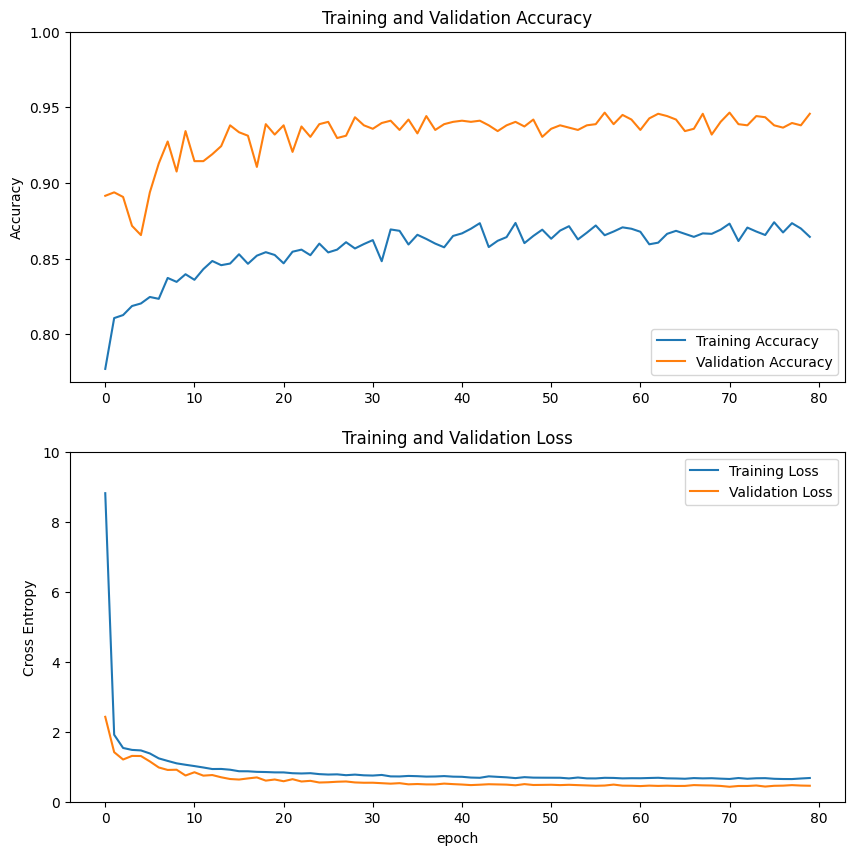

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-Tuning the Base Model and Compiling the Model


- Setting `base_model.trainable = True` allows all layers in the pre-trained base model to be trainable, enabling fine-tuning of the entire network.
- The model is compiled with the following configurations:
  - **Loss function:** `sparse_categorical_crossentropy` is used for multi-class classification tasks where the labels are integers.
  - **Optimizer:** Adam optimizer with a learning rate of `1e-4` is chosen to provide a balance between learning speed and stability during fine-tuning.
  - **Metrics:** Accuracy is used to evaluate the model’s performance during training and validation.
- Calling `model.summary()` outputs a detailed summary of the model architecture, including layer types, output shapes, and the number of parameters (both trainable and non-trainable).

In [14]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

for layer in base_model.layers:
    layer.trainable = True


base_model.trainable = True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  175


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,220,932 (100.02 MB)

 Trainable params: 26,163,716 (99.81 MB)

 Non-trainable params: 57,216 (223.50 KB)

### Training the Model

**Explanation:**

- `total_epochs` specifies the number of epochs to continue training the model.
- The training start time is recorded to measure how long the training process takes.
- The model training resumes from the last completed epoch (`initial_epoch=history.epoch[-1]`) to avoid restarting from scratch.
- Training is performed on the training dataset (`train_ds`) with validation on the validation dataset (`valid_ds`).
- Callbacks are used to save the best model during training and log training progress.
- After training completes, the total duration is calculated and printed in seconds, minutes, and hours.
- A final message confirms that the training has finished.


In [15]:
total_epochs = 180

start_time = time.time()

# Fine-tune the model on the training set
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds,
                         callbacks=(callbacks_list+[csv_logger]))

end_time = time.time()

duration = end_time - start_time

hours, rem = divmod(duration, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training complete in {duration:.2f} seconds ({int(hours)}h {int(minutes)}m {seconds:.2f}s).")

print("Training complete.")

Epoch 80/180
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8182 - loss: 0.8128
Epoch 80: val_accuracy did not improve from 0.94652
815/815 ━━━━━━━━━━━━━━━━━━━━ 282s 315ms/step - accuracy: 0.8182 - loss: 0.8127 - val_accuracy: 0.9450 - val_loss: 0.4061
Epoch 81/180
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8772 - loss: 0.6041
Epoch 81: val_accuracy did not improve from 0.94652
815/815 ━━━━━━━━━━━━━━━━━━━━ 246s 302ms/step - accuracy: 0.8772 - loss: 0.6040 - val_accuracy: 0.9389 - val_loss: 0.3848
Epoch 82/180
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9048 - loss: 0.4852
Epoch 82: val_accuracy improved from 0.94652 to 0.94882, saving model to modelResNet50.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 250s 307ms/step - accuracy: 0.9048 - loss: 0.4852 - val_accuracy: 0.9488 - val_loss: 0.3315
Epoch 83/180
815/815 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9103 - loss: 0.4339
Epoch 83: val_accuracy did not improve from 0.94882
815/815 ━━━━━━━━━━━━━━━━━━━━

### Training and Validation Metrics Visualization

This code cell plots the training and validation accuracy and loss over the epochs to help visualize model performance and convergence.


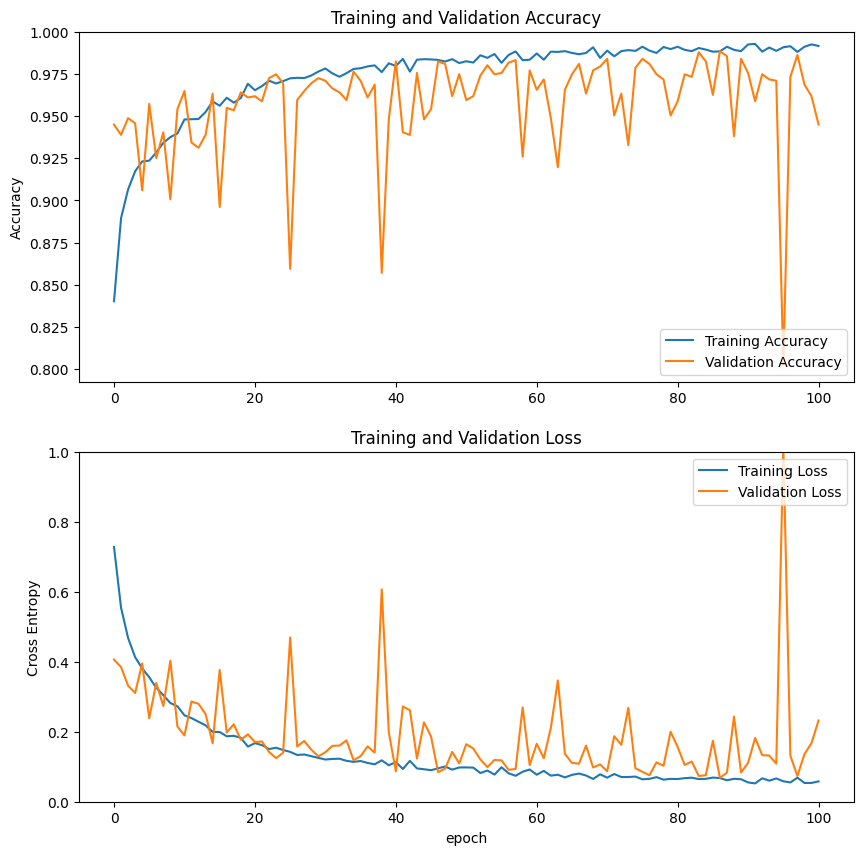

In [16]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate the Model on the Test Set

**Explanation:**

- The `model.evaluate()` method is used to assess the model’s performance on the test dataset.
- It returns the loss value and accuracy metric calculated on the evaluation data.
- These metrics help gauge how well the model generalizes to unseen data.
- The results are printed to provide a clear summary of validation loss and accuracy.


In [17]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(test_ds)
print('Validation loss: {}, Validation accuracy: {}'.format(val_loss, val_acc))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9141 - loss: 0.3098
Validation loss: 0.3381962776184082, Validation accuracy: 0.918749988079071


### Visualizing Predictions on the Validation Set

**Explanation:**

- A single batch of images and their corresponding labels is extracted from the test dataset using `as_numpy_iterator().next()`.
- The model generates predictions for this batch using `predict_on_batch()`.
- A figure is created to display 8 images from the batch in a 4x2 grid.
- For each image:
  - It is displayed using `plt.imshow()`.
  - The actual label is obtained from `label_batch`.
  - The predicted label is determined by selecting the class with the highest probability from the model’s output.

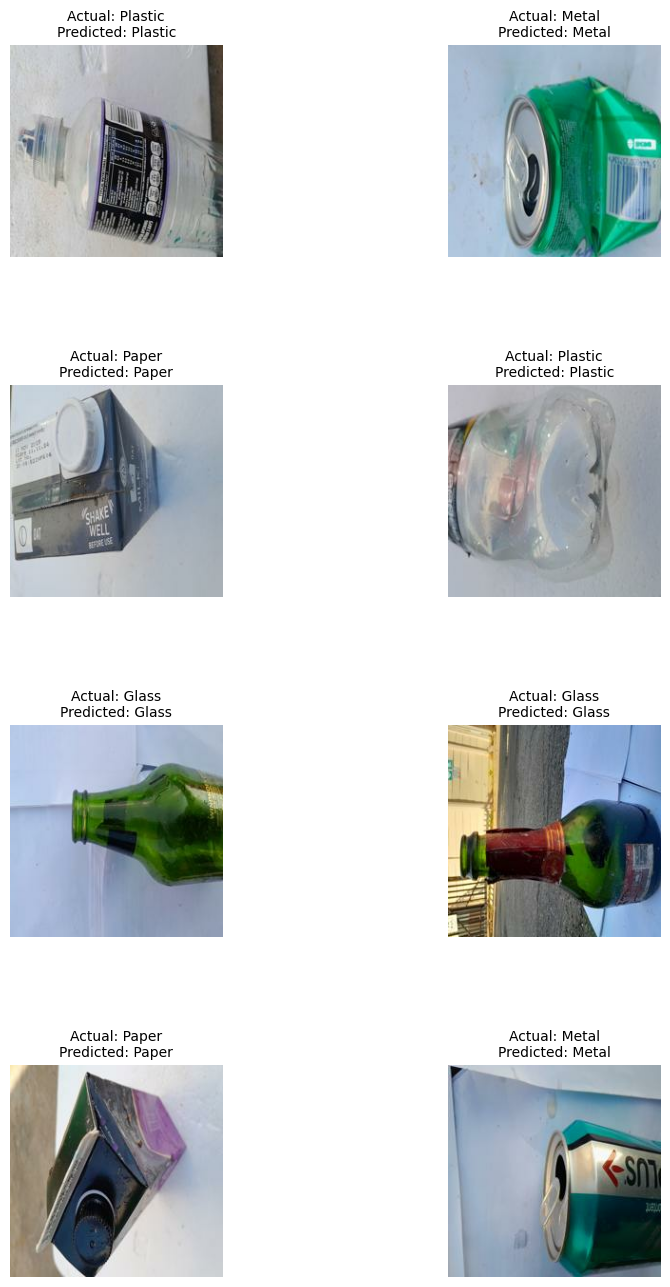

In [18]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

plt.figure(figsize=(10, 16))  # Taller for more vertical space
for i in range(8):
    ax = plt.subplot(4, 2, i + 1)  # 4 rows, 2 columns
    plt.imshow(image_batch[i].astype("uint8"))
    actual_label = class_names[label_batch[i]]
    predicted_label = class_names[np.argmax(predictions[i])]
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    plt.axis("off")

# Adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.6)

plt.show()


### Saving the Trained Model

**Explanation:**

- The `model.save()` function saves the entire trained model to a file named `waste_classification_model_ResNet50.keras`.
- This includes:
  - The model architecture,
  - The learned weights,
  - The training configuration (loss function, optimizer, and metrics),
  - And the optimizer state, which is useful if you want to resume training later.

In [19]:
model.save('waste_classification_model_ResNet50.keras')

### Confusion Matrix for Model Evaluation

**Explanation:**

- The `matplotlib.pyplot` and `sklearn.metrics` libraries are imported to help visualize the model's classification performance using a confusion matrix.
- `y_true` and `y_pred` lists are initialized to store the true and predicted labels, respectively.
- The test dataset is unbatched and then rebatched into smaller batches of 8 images for prediction efficiency.
- For each batch:
  - The model predicts class probabilities.
  - The predicted class is determined by taking the `argmax` of the prediction (i.e., the class with the highest probability).
  - The predicted and true labels are added to their respective lists.
- The `confusion_matrix()` function generates a matrix showing the number of correct and incorrect predictions per class.
- `ConfusionMatrixDisplay` is used to visualize this matrix with class labels (`class_names`) on both axes.

2025-07-23 03:05:32.754932: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


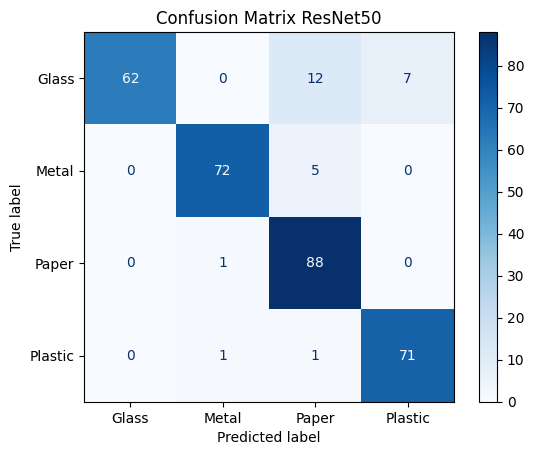

In [20]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
y_true = []
y_pred = []
#class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else ['class_0', 'class_1', 'class_2', 'class_3']

for images, labels in test_ds.unbatch().batch(8):
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix ResNet50")
plt.show()
